In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from os.path import expanduser
import seaborn as sns
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches

In [2]:
DETECTS_3DID_NAME = 'minvi-600-2021-12-19-02-35-34'
DETECTS_3DID_DIR = '/media/big-ssd/results-P3856_YHE211-3did/{}/P3856_YHE211/features-3did'.format(DETECTS_3DID_NAME)
DETECTS_3DID_FILE = '{}/exp-P3856_YHE211-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather'.format(DETECTS_3DID_DIR)

In [3]:
# load the 3DID features classified as identifiable
detects_3did_df = pd.read_feather(DETECTS_3DID_FILE)

In [4]:
detects_3did_df.sample(n=4)

,index,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,inverse_k0_apex,rt_apex,rt_lower,rt_upper,...,voxel_id,voxel_metadata_d,scan_df,scan_r_squared,rt_df,rt_r_squared,number_of_frames,feature_id,prediction,identification_predicted
68693,7776,734.339844,734.386597,167.0,142.0,177.0,1.232928,2071.723389,2069.606689,2074.370117,...,640035507,"{""mz_lower"": 734.3000000000001, ""mz_upper"": 73...","[{""scan"":129,""inverse_k0"":1.2521133423,""intens...",0.996470,"[{""frame_id"":18487,""retention_time_secs"":2060....",0.982453,10,233066,0.320860,True
73947,3272,756.344910,756.393127,118.0,81.0,128.0,1.257664,1776.412354,1773.236450,1783.294189,...,660015016,"{""mz_lower"": 757.3000000000001, ""mz_upper"": 75...","[{""scan"":49,""inverse_k0"":1.2924461365,""intensi...",0.998452,"[{""frame_id"":15657,""retention_time_secs"":1761....",0.981554,20,249796,0.288962,True
75992,1910,762.040649,762.089172,773.0,762.0,778.0,0.924611,2293.481934,2290.306396,2298.481934,...,670008975,"{""mz_lower"": 762.4, ""mz_upper"": 762.5, ""scan_l...","[{""scan"":744,""inverse_k0"":0.9394677877,""intens...",0.838123,"[{""frame_id"":20567,""retention_time_secs"":2280....",0.903044,10,256899,0.741329,True
38065,11095,654.814636,654.856323,689.0,684.0,707.0,0.967616,1784.882568,1779.882568,1787.527466,...,560055188,"{""mz_lower"": 654.8000000000001, ""mz_upper"": 65...","[{""scan"":682,""inverse_k0"":0.9711956382,""intens...",-14.903901,"[{""frame_id"":15872,""retention_time_secs"":1783....",0.940632,8,133671,0.285095,True


In [5]:
detects_3did_df.columns

Index(['index', 'mono_mz_lower', 'mono_mz_upper', 'scan_apex', 'scan_lower',
       'scan_upper', 'inverse_k0_apex', 'rt_apex', 'rt_lower', 'rt_upper',
       'intensity_without_saturation_correction',
       'intensity_with_saturation_correction',
       'mono_intensity_adjustment_outcome', 'isotopic_peaks', 'isotope_count',
       'envelope', 'coelution_coefficient', 'mobility_coefficient',
       'voxels_processed', 'monoisotopic_mz', 'charge', 'neutral_mass',
       'monoisotopic_mass', 'feature_intensity', 'deconvolution_envelope',
       'deconvolution_score', 'feature_region_3d_extent', 'voxel_id',
       'voxel_metadata_d', 'scan_df', 'scan_r_squared', 'rt_df',
       'rt_r_squared', 'number_of_frames', 'feature_id', 'prediction',
       'identification_predicted'],
      dtype='object')

In [93]:
biosaur_name = 'P3856_YHE211_1_Slot1-1_1_5104-denoised-biosaur-mini-100-ac-25-minl-6.features.tsv'
DETECTS_BIOSAUR_FILE = '{}/{}'.format(expanduser('~'), biosaur_name)


In [94]:
detects_biosaur_df = pd.read_csv(DETECTS_BIOSAUR_FILE, sep='\\t', engine='python')

In [95]:
detects_biosaur_df = detects_biosaur_df[(detects_biosaur_df.nIsotopes >= 3)]

In [96]:
detects_biosaur_df.columns

Index(['massCalib', 'rtApex', 'intensityApex', 'charge', 'nIsotopes', 'nScans',
       'sulfur', 'cos_corr_1', 'cos_corr_2', 'diff_for_output',
       'corr_fill_zero', 'intensity_1', 'scan_id_1', 'mz_std_1', 'intensity_2',
       'scan_id_2', 'mz_std_2', 'mz', 'rtStart', 'rtEnd', 'id', 'ion_mobility',
       'FAIMS', 'targeted_mode'],
      dtype='object')

In [116]:
# corresponds to about the same scan tolerance as 20 scans over 910
DUP_INVERSE_K0 = (detects_3did_df.inverse_k0_apex.max()-detects_3did_df.inverse_k0_apex.min())*(20/910) * 4
DUP_INVERSE_K0 = 0.01

In [117]:
# definition of a duplicate feature
DUP_MZ_TOLERANCE_PPM = 10
DUP_RT_TOLERANCE = 10

In [118]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
detects_biosaur_df['dup_mz_ppm_tolerance'] = detects_biosaur_df.mz * MZ_TOLERANCE_PERCENT / 100
detects_biosaur_df['dup_mz_lower'] = detects_biosaur_df.mz - detects_biosaur_df.dup_mz_ppm_tolerance
detects_biosaur_df['dup_mz_upper'] = detects_biosaur_df.mz + detects_biosaur_df.dup_mz_ppm_tolerance
detects_biosaur_df['dup_inverse_k0_lower'] = detects_biosaur_df.ion_mobility - DUP_INVERSE_K0
detects_biosaur_df['dup_inverse_k0_upper'] = detects_biosaur_df.ion_mobility + DUP_INVERSE_K0
detects_biosaur_df['dup_rt_lower'] = detects_biosaur_df.rtApex - DUP_RT_TOLERANCE
detects_biosaur_df['dup_rt_upper'] = detects_biosaur_df.rtApex + DUP_RT_TOLERANCE

In [119]:
# find the features detected by 3DID and Biosaur
matched_features_3did = set()
matched_features_biosaur = set()

for row in detects_3did_df.itertuples():
    df = detects_biosaur_df[(row.charge == detects_biosaur_df.charge) & (row.monoisotopic_mz >= detects_biosaur_df.dup_mz_lower) & (row.monoisotopic_mz <= detects_biosaur_df.dup_mz_upper) & (row.inverse_k0_apex >= detects_biosaur_df.dup_inverse_k0_lower) & (row.inverse_k0_apex <= detects_biosaur_df.dup_inverse_k0_upper) & (row.rt_apex >= detects_biosaur_df.dup_rt_lower) & (row.rt_apex <= detects_biosaur_df.dup_rt_upper)]
    if len(df) > 0:
        matched_features_3did.update(set([row.feature_id]))
        matched_features_biosaur.update(set(df.id.tolist()))

In [120]:
contained_in_3did_not_biosaur = len(detects_3did_df) - len(matched_features_3did)
contained_in_biosaur_not_3did = len(detects_biosaur_df) - len(matched_features_biosaur)
contained_in_both = len(matched_features_biosaur)

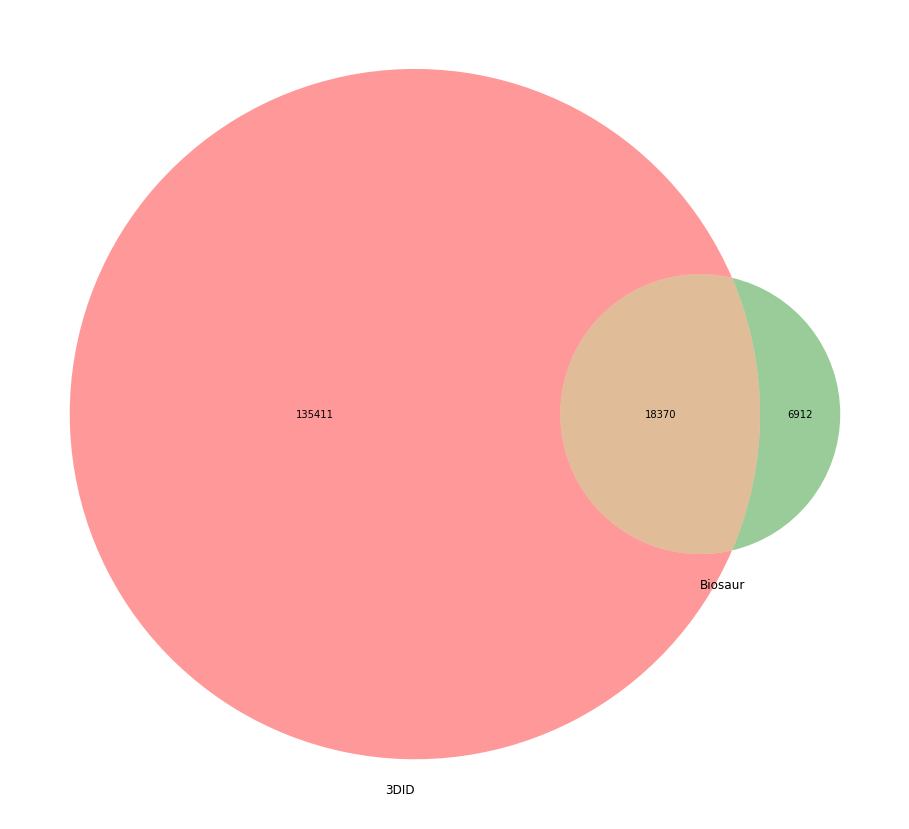

In [121]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(20)

plt.margins(0.06)

venn2(subsets = (contained_in_3did_not_biosaur, contained_in_biosaur_not_3did, contained_in_both), set_labels = ('3DID', 'Biosaur'))
plt.show()

In [122]:
matched_3did_df = detects_3did_df[detects_3did_df.feature_id.isin(matched_features_3did)]

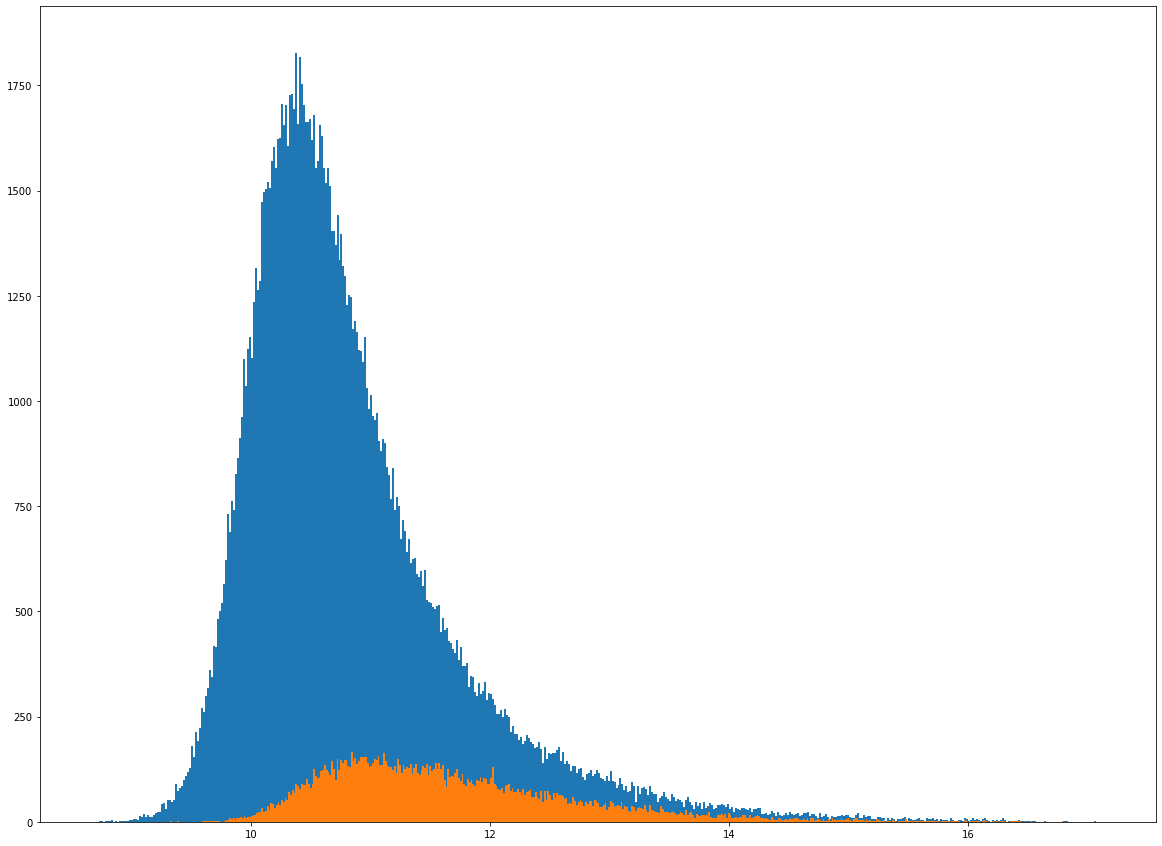

In [123]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(20)

plt.margins(0.06)

bins = 500
values = np.log2(detects_3did_df.feature_intensity)
y, x, _ = ax.hist(values, bins=bins, label='detected')

values = np.log2(matched_3did_df.feature_intensity)
y, x, _ = ax.hist(values, bins=bins, label='matched')

plt.show()

In [124]:
detects_biosaur_df[~detects_biosaur_df.id.isin(matched_features_biosaur)]

,massCalib,rtApex,intensityApex,charge,nIsotopes,nScans,sulfur,cos_corr_1,cos_corr_2,diff_for_output,...,ion_mobility,FAIMS,targeted_mode,dup_mz_ppm_tolerance,dup_mz_lower,dup_mz_upper,dup_inverse_k0_lower,dup_inverse_k0_upper,dup_rt_lower,dup_rt_upper
0,2241.009043,1937.838572,18156.0,2,10,15,0,0.937998,1.0,-5.712363e-07,...,1.254014,0,[],0.011215,1121.500583,1121.523013,1.244014,1.264014,1927.838572,1947.838572
2,2353.136596,2101.365671,8433.0,2,10,18,0,0.756970,1.0,-8.600336e-07,...,1.270320,0,[],0.011776,1177.563799,1177.587350,1.260320,1.280320,2091.365671,2111.365671
4,6343.933596,1772.176983,14197.0,6,9,18,0,0.979981,1.0,-5.859001e-07,...,1.104739,0,[],0.010583,1058.318959,1058.340126,1.094739,1.114739,1762.176983,1782.176983
11,1944.927083,2252.206361,10558.0,2,10,10,0,0.837177,1.0,-4.121965e-07,...,1.208280,0,[],0.009735,973.461083,973.480552,1.198280,1.218280,2242.206361,2262.206361
13,6639.718460,1661.558729,1426.0,5,8,6,0,0.996928,1.0,6.290841e-07,...,1.135723,0,[],0.013290,1328.937679,1328.964258,1.125723,1.145723,1651.558729,1671.558729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60002,647.326702,1926.196737,1312.0,1,3,10,0,0.625319,1.0,-4.726428e-06,...,1.217770,0,[],0.006483,648.327495,648.340462,1.207770,1.227770,1916.196737,1936.196737
60018,531.270851,985.321020,2277.0,1,3,19,0,0.610132,1.0,5.361777e-06,...,1.076677,0,[],0.005323,532.272805,532.283451,1.066677,1.086677,975.321020,995.321020
60025,585.308871,568.789872,495.0,1,3,16,0,0.616992,1.0,-7.458335e-06,...,1.129462,0,[],0.005863,586.310284,586.322010,1.119462,1.139462,558.789872,578.789872
60032,531.284116,430.423186,1211.0,1,3,9,0,0.611362,1.0,3.237729e-06,...,1.077798,0,[],0.005323,532.286070,532.296716,1.067798,1.087798,420.423186,440.423186
